# Projet


# Installation des librairies

In [64]:
!pip install -r requirements.txt

# Liste des imports

In [65]:
import random
import requests
import tarfile
import os
import json
import webcolors
import numpy
import math
import webcolors
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from PIL import Image, ExifTags, ImageColor
from sklearn.cluster import MiniBatchKMeans


## Collecte de données et Etiquetage des informations
Nous commencons par créer notre dossier images, dans le repertoire courant.

In [66]:

URL_IMAGES = 'https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz'
IMAGES_PATH = "images/"
FICHIER_JSON = "json_data.json"

# Création du dossier images
if os.path.exists(IMAGES_PATH) is False :
    os.mkdir(IMAGES_PATH)

# Téléchargement des images
if(os.path.exists("images.tar.gz")) is False :
    print('Téléchargement des images...')
    req = requests.get(URL_IMAGES)
    print('Téléchargement fini')

    # Extraction des images
    print("Extraction des images...")
    filename = URL_IMAGES.split('/')[-1]
    with open(filename,'wb') as output_file:
        output_file.write(req.content)
    tar = tarfile.open(filename, "r:gz")
    tar.extractall()
    tar.close()
    print("Extraction des images fini")

    # Suppression des fichiers temporaires
    print("Suppression des fichiers temporaires")
    os.remove("images.tar.gz")


Création du JSON et sauvegardes des informations sur l'images. Ce fichier contient les données EXIF trouvés ainsi que les couleurs prédominantes que nous avons analysés.

In [67]:
# Création du JSON avec les EXIF des images
jsonImages = {}
info_dict = []
raceChien = [
    'american'
    'basset',
    'ceagle',
    'boxer',
    'chihuahua',
    'english',
    'german_Shorthaired',
    'great_Pyrenees',
    'havanese',
    'japanese',
    'keeshond',
    'leonberger',
    'miniature',
    'newfoundland',
    'pomeranian',
    'pug',
    'saint',
    'samyoed',
    'scottish',
    'shiba',
    'staffordshire',
    'wheaten',
    'yorkshire'
]

def couleurProche(couleur):
    couleurs = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - couleur[0]) ** 2
        gd = (g_c - couleur[1]) ** 2
        bd = (b_c - couleur[2]) ** 2
        couleurs[(rd + gd + bd)] = name
    return couleurs[min(couleurs.keys())]

def getNomCouleurs(couleur):
    try:
        nom = nomActuel = webcolors.rgb_to_name(couleur)
    except ValueError:
        nom = couleurProche(couleur)
        nomActuel = None
    return nomActuel, nom

def recupererCouleurs(image):
    couleursPredominante = []

    numarray = numpy.array(image.getdata(), numpy.uint8)
    clusters = MiniBatchKMeans(n_clusters = 3)
    clusters.fit(numarray)
    npbins = numpy.arange(0, 4)
    histogram = numpy.histogram(clusters.labels_, bins=npbins)
    labels = numpy.unique(clusters.labels_)

    for i in range(3):
        hexColor = ('#%02x%02x%02x' % (
            math.ceil(clusters.cluster_centers_[i][0]), 
            math.ceil(clusters.cluster_centers_[i][1]),
            math.ceil(clusters.cluster_centers_[i][2])))
        rgbColor = ImageColor.getcolor(hexColor, "RGB")
        actual_name, closest_name = getNomCouleurs(rgbColor)
        if(actual_name != None):
            couleursPredominante.append(actual_name)
        else:
            couleursPredominante.append(closest_name)
    
    return couleursPredominante


# Parcours de toutes les images du dossier
print("Parcours du dossier en cours...")
for fichier in os.listdir(IMAGES_PATH):
    if fichier.endswith ('.jpg'):
        if(int(fichier.split("_")[len(fichier.split("_")) - 1].split(".")[0]) <= 10):
            cheminFichier = os.path.join(IMAGES_PATH, fichier)
            image = Image.open(cheminFichier)

            # Récupération des EXIF
            info_dict = {
                "Race" : fichier.split("_")[0],
                "Image Hauteur": image.height,
                "Image Largeur": image.width,
                "Mode": image.mode,
                "Orientation": "Portrait" if image.height > image.width else "Paysage", 
                "Image anime": getattr(image, "is_animated", False),
            }

            # Récupération des infos sur l'image
            if info_dict["Race"] in raceChien:
                info_dict["Animal"] = "Chiens"
            else:
                info_dict["Animal"] = "Chats"

            # Récupération des couleurs
            if(image.mode != "RGB"):
                image = image.convert("RGB")
            info_dict["Couleurs"] = recupererCouleurs(image);
            
            jsonImages[fichier] = info_dict

with open('json_data.json', 'w') as outfile:
    json.dump(jsonImages, outfile, indent=4, separators=(',',': '))
outfile.close()
print("Parcours du dossier terminé")

Parcours du dossier en cours...
Parcours du dossier terminé


## Analyses des données

Nous allons maintenant créer 5 utilisateurs "test". Nous sélectionnerons 100 images de manière aléatoires de notre dossier d'images. De plus, nous leurs affecterons de manière aléatoire une valeur "J'aime" et "J'aime pas".

In [68]:
NOMBRE_UTILISATEUR = 4

nomImages = []
utilisateursTest = []

# Ouverture du JSON
listeImages = json.load(open('json_data.json'))

# Récupération du nom des images
for key in listeImages.keys():
    nomImages.append(key)

# Affectation des images aux utilisateurs avec leurs avis
for i in range(NOMBRE_UTILISATEUR):
    preferences = {}
    for j in range(100):

        # Récupération d'une image et d'un avis aléatoire 
        image = random.randrange(0, len(listeImages))
        avis = random.randrange(0, 2)

        # Affectation à l'utilisateur
        preferences[nomImages[image]] = "J'aime" if avis == 1 else "J'aime pas"
    utilisateursTest.append(preferences)

Avec les informations des utilisateurs, nous pouvons maintenant créer un dataframes allant servir par la suite

In [75]:
dataframe = []
favoris = []

infosImage = [
    "Image", 
    "Race",
    "Animal",
    "Image Hauteur",
    "Image Largeur", 
    "Couleur1",
    "Couleur2", 
    "Couleur3"
]

colonneDataframe = [ 
    "Race",
    "Animal",
    "Image Hauteur",
    "Image Largeur", 
    "Couleur1",
    "Couleur2",
    "Couleur3"
]

# Création des labels
labels = []
for _ in colonneDataframe:
    labels.append(LabelEncoder())
labelFavoris = LabelEncoder()

# Parcours des utilisateurs
for i in range(len(utilisateursTest)):
    preferences = utilisateursTest[i]
    infoDataframe = []
    favorisDataframe = []

    for key in preferences.keys():
        image = listeImages[key]
        
        # Récupération des couleurs
        couleur1 = image["Couleurs"][0]
        couleur2 = image["Couleurs"][1]
        couleur3 = image["Couleurs"][2]

        # Ajout aux dataframes de toutes les infos de l'image
        infoDataframe.append([key, image["Race"], image["Animal"], image["Image Hauteur"], image["Image Largeur"], couleur1, couleur2, couleur3])
        favorisDataframe.append(preferences[key])
    
    # Création des dataframes
    dataframe.append(pd.DataFrame(infoDataframe, columns=infosImage))
    favoris.append(pd.DataFrame(favorisDataframe, columns=["Avis"]))

print(favoris)

[          Avis
0       J'aime
1   J'aime pas
2       J'aime
3       J'aime
4       J'aime
..         ...
81  J'aime pas
82  J'aime pas
83      J'aime
84  J'aime pas
85  J'aime pas

[86 rows x 1 columns],           Avis
0       J'aime
1   J'aime pas
2   J'aime pas
3       J'aime
4       J'aime
..         ...
86  J'aime pas
87      J'aime
88  J'aime pas
89  J'aime pas
90      J'aime

[91 rows x 1 columns],           Avis
0       J'aime
1   J'aime pas
2       J'aime
3   J'aime pas
4   J'aime pas
..         ...
82  J'aime pas
83      J'aime
84  J'aime pas
85  J'aime pas
86      J'aime

[87 rows x 1 columns],           Avis
0       J'aime
1   J'aime pas
2   J'aime pas
3       J'aime
4       J'aime
..         ...
78      J'aime
79  J'aime pas
80      J'aime
81  J'aime pas
82      J'aime

[83 rows x 1 columns]]


## Visualisation des données

Avec nos dataframes, nous allons récupérés les images aimés aléatoirement par nos utilisateurs. Une fois fait, nous allons afficher les images dont la race est aimé par l'utilisateur

In [70]:
NOMBRE_UTILISATEUR = 4
utilisateursImageAime = []
infoUtilisateur = []

# Parcours des utilisateurs
for i in range(NOMBRE_UTILISATEUR):
    imageAime = []
    dataframes = favoris[i]

    # Parcours du dataframe
    for index, row in dataframes.iterrows():
        if(row["Avis"]) == "J'aime":
            # On associe une image aimé à un utilisateur
            imageAime.append(index)

    utilisateurAime = [dataframe[i].iloc[j]["Image"] for j in imageAime]
    utilisateursImageAime.append(utilisateurAime)
    

for i in range (NOMBRE_UTILISATEUR):
    info = {}
    info["Couleurs"] = {}
    info["Chiens"] = {
        "total": 0,
        "Race" : {}
    }
    info["Chats"] = {
        "total": 0,
        "Race" : {}
    }

    for image in utilisateursImageAime[i]:
        # Récupération des informations de l'image
        imageInfo = listeImages[image]
        couleurs = imageInfo["Couleurs"]
        race = imageInfo["Race"]
        animal = imageInfo["Animal"]
        listeRaces = info[animal]["Race"]

        # On augmente le nombre total d'animal
        info[animal]["total"] = info[animal]["total"] + 1
        listeRaces = info[animal]["Race"]
        
        # Ajout des races détéctés dans la liste des races
        if race not in listeRaces:
            listeRaces[race] = 1
        else:
            listeRaces[race] = listeRaces[race] + 1
        
        # Ajout des couleurs
        couleursImage = info["Couleurs"]
        for j in couleurs:
            if j not in couleursImage:
                couleursImage[j] = 1
            else:
                couleursImage[j] = couleursImage[j] + 1
    infoUtilisateur.append(info)
    print(info)

{'Couleurs': {'darkgray': 10, 'darkslategray': 27, 'darkolivegreen': 11, 'dimgray': 17, 'black': 13, 'tan': 4, 'gainsboro': 7, 'gray': 20, 'linen': 1, 'indianred': 1, 'rosybrown': 9, 'peru': 2, 'whitesmoke': 1, 'wheat': 2, 'silver': 13, 'sienna': 3, 'saddlebrown': 3, 'lightgray': 6, 'cadetblue': 1, 'darkseagreen': 1, 'skyblue': 1, 'midnightblue': 1, 'white': 1, 'sandybrown': 1}, 'Chiens': {'total': 29, 'Race': {'japanese': 3, 'keeshond': 4, 'newfoundland': 3, 'miniature': 1, 'english': 2, 'leonberger': 4, 'shiba': 2, 'pomeranian': 4, 'pug': 1, 'scottish': 2, 'chihuahua': 1, 'havanese': 1, 'wheaten': 1}}, 'Chats': {'total': 23, 'Race': {'american': 5, 'beagle': 1, 'Sphynx': 1, 'Birman': 2, 'german': 2, 'basset': 2, 'Egyptian': 2, 'Abyssinian': 1, 'British': 1, 'Ragdoll': 4, 'Bengal': 1, 'Maine': 1}}}
{'Couleurs': {'darkslategray': 26, 'rosybrown': 9, 'dimgray': 16, 'lightslategray': 1, 'black': 10, 'gray': 15, 'lightsteelblue': 2, 'darkgray': 8, 'lightblue': 2, 'tan': 5, 'lightgray': 5,

Avec nos données, nous allons maintenant afficher les statistiques de notre recherche.

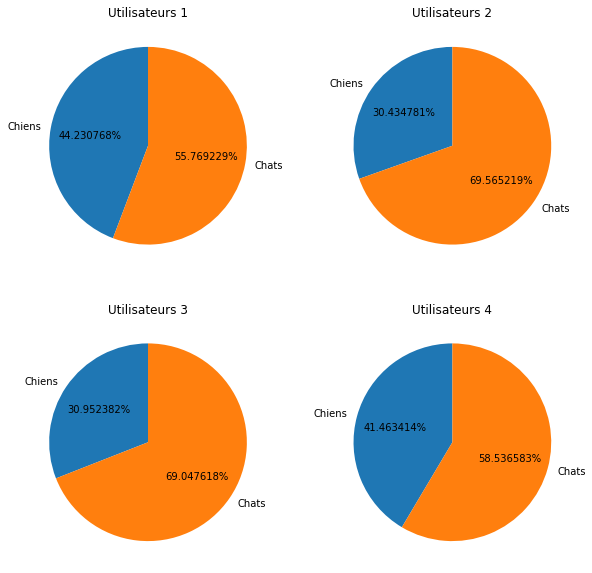

In [74]:

indexAxes = [[0,0], [0,1], [1,0], [1,1]]

graphiques, axes = plt.subplots(nrows=2,ncols=2,  figsize=(10,10))

# Parcours la liste des infos de chaque utilisateurs
for i, imageAime in enumerate(infoUtilisateur):
    # On défini les labels à afficher
    labelsGraphe = ["Chiens","Chats"]
    sizes = [imageAime["Chats"]["total"],imageAime["Chiens"]["total"]]

    # On ajoute un titre à chaque graphe
    axes[indexAxes[i][0],indexAxes[i][1]].set_title(f"Utilisateurs {i+1}")

    # On défini les paramètres de chaque graphiques
    axes[indexAxes[i][0],indexAxes[i][1]].pie(sizes, labels=labels, autopct='%1f%%', startangle=90)
plt.show()

## Système de Recommandation

Pour créer notre système de recommendation, nous allons utiliser des "Decision Trees", pour chaque utilisateurs avec leurs images favorites.

In [77]:
trees = []
df = [dataframes.loc[:, "Race":"Couleur3"] for dataframes in dataframe]

for dataframes in df:
    for i, colonne in enumerate(colonneDataframe):
        dataframes[colonne] = labels[i].fit_transform(dataframes[colonne])

# Parcours des images aimées
for dataframesAime in favoris:
    dataframesAime["Avis"] = labelFavoris.fit_transform(dataframesAime["Avis"])

for i in range(NOMBRE_UTILISATEUR):
    # Création des arbres
    decisionTree = tree.DecisionTreeClassifier()
    decisionTree = decisionTree.fit(df[i], favoris[i])
    trees.append(decisionTree)


[DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier()]


## Tests
Pour tester notre système de recommendation, nous allons tester avec un utilisateur qui a aimé toutes les images de chaque race de chien